### Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import json
import pickle
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Read the image
img_arr = cv2.imread('/content/drive/MyDrive/Major Project/test-emotion-detection/Self Created Dataset and Detection/self dataset 5/dataset-cropped_image 5/angry/Angry1.png')
img_arr.shape

(184, 184, 3)

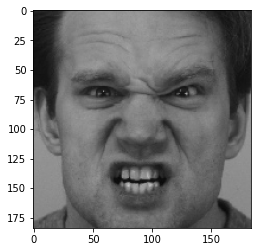

In [ ]:
plt.imshow(img_arr)
plt.show()

In [ ]:
gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
gray.shape

(184, 184)

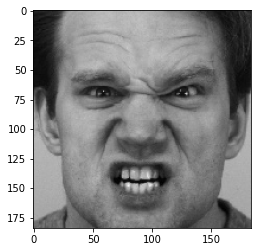

In [ ]:
plt.imshow(gray, cmap='gray')
plt.show()

In [ ]:
### Training dataset
datadirectory = '/content/drive/MyDrive/Major Project/test-emotion-detection/Self Created Dataset and Detection/self dataset 5/dataset-cropped_image 5/'

In [ ]:
img_dirs = []
for entry in os.scandir(datadirectory):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [ ]:
img_dirs

['/content/drive/MyDrive/Major Project/test-emotion-detection/Self Created Dataset and Detection/self dataset 5/dataset-cropped_image 5/fear',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/Self Created Dataset and Detection/self dataset 5/dataset-cropped_image 5/sad',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/Self Created Dataset and Detection/self dataset 5/dataset-cropped_image 5/angry',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/Self Created Dataset and Detection/self dataset 5/dataset-cropped_image 5/happy',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/Self Created Dataset and Detection/self dataset 5/dataset-cropped_image 5/surprise',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/Self Created Dataset and Detection/self dataset 5/dataset-cropped_image 5/neutral',
 '/content/drive/MyDrive/Major Project/test-emotion-detection/Self Created Dataset and Detection/self dataset 5/dataset-cropped_image 

In [ ]:
emotions = []
for img_dir in img_dirs:
    emotion_name = img_dir.split('/')[-1]
    emotions.append(emotion_name)

In [ ]:
emotions

['fear', 'sad', 'angry', 'happy', 'surprise', 'neutral', 'disgust']

### Read all the images and converting them into array

In [ ]:
training_data = []

for emotion in emotions:
    path = os.path.join(datadirectory, emotion)
    label = emotions.index(emotion)
    print('{} --> {}'.format(emotion, label))
    for img in os.listdir(path):
        imgpath = os.path.join(path, img)
        emotion_img = cv2.imread(imgpath)
        emotion_img = cv2.cvtColor(emotion_img, cv2.COLOR_BGR2GRAY)
        try:
            emotion_img = cv2.resize(emotion_img, (48, 48))
            image = np.array(emotion_img).flatten()      
            training_data.append([image, label])
        except Exception as e:
            pass

fear --> 0
sad --> 1
angry --> 2
happy --> 3
surprise --> 4
neutral --> 5
disgust --> 6


In [ ]:
print(len(training_data))

4336


In [ ]:
import random 
random.shuffle(training_data)

In [ ]:
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

### Splitting the data into training and test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

### Training the model with different machine learning models

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [ ]:
scores = []
best_estimators = {}
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.767836,"{'svc__C': 10, 'svc__kernel': 'rbf'}"
1,random_forest,0.594102,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.696802,{'logisticregression__C': 1}


In [ ]:
best_estimators

{'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(C=10, gamma='auto', probability=True))])}

In [ ]:
best_estimators['svm'].score(X_test,y_test)

0.7693726937269373

In [ ]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.6826568265682657

In [ ]:
best_estimators['random_forest'].score(X_test,y_test)

0.6116236162361623

In [ ]:
best_clf_svm = best_estimators['svm']

In [ ]:
best_clf_svm

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10, gamma='auto', probability=True))])

In [ ]:
cm_svm = confusion_matrix(y_test, best_clf_svm.predict(X_test))
cm_svm

array([[ 85,  16,   7,   3,  15,   3,   1],
       [  7,  98,   7,   2,   4,  13,   8],
       [  8,   9, 103,   1,   8,   8,  16],
       [  1,   2,   3, 150,   0,   3,   6],
       [ 14,   1,   5,   3, 122,   3,   4],
       [  5,  12,   7,   2,   3, 154,   4],
       [  7,   9,  12,   3,   1,   4, 122]])

Text(69.0, 0.5, 'Truth')

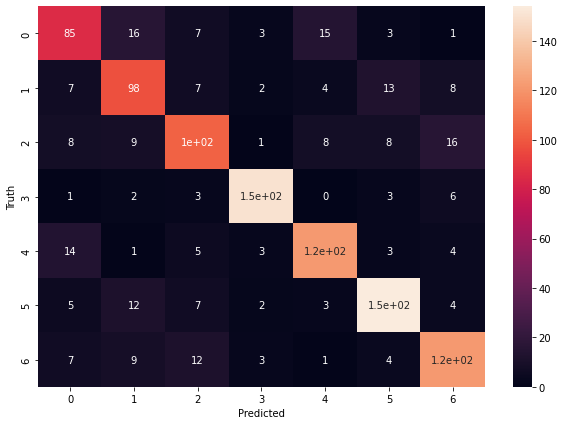

In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(cm_svm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
cr_svm = classification_report(y_test, best_clf_svm.predict(X_test))
print(cr_svm)

              precision    recall  f1-score   support

           0       0.67      0.65      0.66       130
           1       0.67      0.71      0.69       139
           2       0.72      0.67      0.69       153
           3       0.91      0.91      0.91       165
           4       0.80      0.80      0.80       152
           5       0.82      0.82      0.82       187
           6       0.76      0.77      0.76       158

    accuracy                           0.77      1084
   macro avg       0.76      0.76      0.76      1084
weighted avg       0.77      0.77      0.77      1084



In [ ]:
cr_svm = classification_report(y_test, best_clf_svm.predict(X_test))
print(cr_svm)

              precision    recall  f1-score   support

           0       0.67      0.65      0.66       130
           1       0.67      0.71      0.69       139
           2       0.72      0.67      0.69       153
           3       0.91      0.91      0.91       165
           4       0.80      0.80      0.80       152
           5       0.82      0.82      0.82       187
           6       0.76      0.77      0.76       158

    accuracy                           0.77      1084
   macro avg       0.76      0.76      0.76      1084
weighted avg       0.77      0.77      0.77      1084



In [ ]:
best_clf_logistic_reg = best_estimators['logistic_regression']

In [ ]:
best_clf_logistic_reg

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1, solver='liblinear'))])

In [ ]:
cm_logistic_reg = confusion_matrix(y_test, best_clf_logistic_reg.predict(X_test))
cm_logistic_reg

array([[ 64,  18,   8,   5,  21,   8,   6],
       [ 11,  79,  12,   5,   5,  21,   6],
       [ 10,  11,  86,   4,   6,  11,  25],
       [  4,   6,   0, 139,   4,   1,  11],
       [ 13,   1,   3,   5, 116,  10,   4],
       [  5,   6,   6,   4,   8, 151,   7],
       [  7,   8,  24,   3,   4,   7, 105]])

Text(69.0, 0.5, 'Truth')

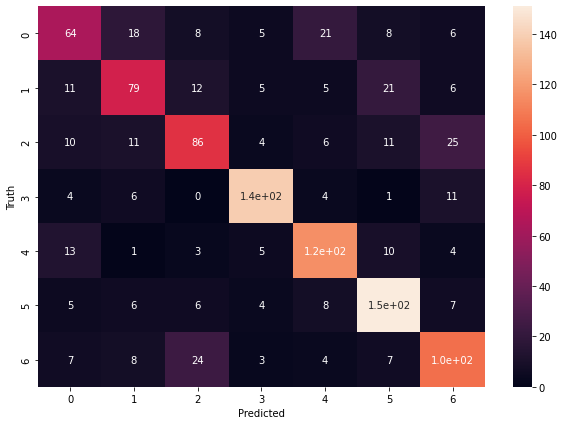

In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(cm_logistic_reg, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
cr_logistic_reg = classification_report(y_test, best_clf_logistic_reg.predict(X_test))
print(cr_logistic_reg)

              precision    recall  f1-score   support

           0       0.56      0.49      0.52       130
           1       0.61      0.57      0.59       139
           2       0.62      0.56      0.59       153
           3       0.84      0.84      0.84       165
           4       0.71      0.76      0.73       152
           5       0.72      0.81      0.76       187
           6       0.64      0.66      0.65       158

    accuracy                           0.68      1084
   macro avg       0.67      0.67      0.67      1084
weighted avg       0.68      0.68      0.68      1084



In [ ]:
with open("/content/drive/MyDrive/Major Project/test-emotion-detection/Self Created Dataset and Detection/self dataset 5/Models/model5.pkl", "wb") as f:
  pickle.dump(best_clf_svm, f)